# Importar librerías para entrenar los modelos

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency # para ver relación entre y y variables categóricas
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, classification_report, roc_auc_score
from sklearn.svm import SVC
from pprint import pprint
from subprocess import check_output
import xgboost as xgb

import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

In [3]:
import os
print("File location using os.getcwd():", os.getcwd())

File location using os.getcwd(): /Users/sebastiangiraldogonzalez/Maestría/Proyecto Integrador 2


# Modelos a evaluar


## Cargamos los datos y separamos en X,y

In [4]:
df= pd.read_csv('/Users/sebastiangiraldogonzalez/Maestría/Proyecto Integrador 2/data_pca.csv')
df.head()

,Customer_ID,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Credit_Score
0,3392,-1.432269,0.093852,-2.278188,-1.407816,-0.135649,-1.996803,0.275828,-0.648048,1.313756,...,0.667774,0.094029,-0.093014,-1.100186,-1.494958,1.076635,-1.688978,0.175915,-0.819142,2
1,3392,-1.698989,0.418354,-1.785871,-1.361343,-0.131089,-1.898032,0.406715,-0.559605,1.350804,...,0.595757,-0.238172,0.142565,-1.179211,-1.534768,0.976853,-1.743069,0.064623,-0.666969,2
2,3392,-1.501422,0.479586,-1.432461,-1.360819,-0.066890,-1.854806,0.282160,-0.416728,1.355014,...,1.041039,0.708216,-0.509633,-1.109486,-1.522738,1.003116,-1.690114,0.156681,-0.533545,2
3,3392,-1.682258,0.101027,-2.322815,-1.393282,-0.149784,-1.995335,0.318837,-0.708591,1.318216,...,0.514263,-0.515451,0.413239,-1.106747,-1.530995,0.928847,-1.573458,0.124982,-0.749807,2
4,3392,-1.582761,0.624981,-1.505005,-1.382160,-0.070191,-1.849546,0.218287,-0.380822,1.363299,...,1.189984,1.238533,-0.868051,-1.067568,-1.493789,1.074852,-1.702390,0.253632,-0.557135,2


In [5]:
index=df['Customer_ID']

In [6]:
X = df.iloc[:,1:-1]
y = df.iloc[:,28]

In [7]:
X.head()

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z18,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27
0,-1.432269,0.093852,-2.278188,-1.407816,-0.135649,-1.996803,0.275828,-0.648048,1.313756,-0.713133,...,0.575968,0.667774,0.094029,-0.093014,-1.100186,-1.494958,1.076635,-1.688978,0.175915,-0.819142
1,-1.698989,0.418354,-1.785871,-1.361343,-0.131089,-1.898032,0.406715,-0.559605,1.350804,-0.727694,...,0.592985,0.595757,-0.238172,0.142565,-1.179211,-1.534768,0.976853,-1.743069,0.064623,-0.666969
2,-1.501422,0.479586,-1.432461,-1.360819,-0.066890,-1.854806,0.282160,-0.416728,1.355014,-0.817413,...,0.454585,1.041039,0.708216,-0.509633,-1.109486,-1.522738,1.003116,-1.690114,0.156681,-0.533545
3,-1.682258,0.101027,-2.322815,-1.393282,-0.149784,-1.995335,0.318837,-0.708591,1.318216,-0.665006,...,0.666473,0.514263,-0.515451,0.413239,-1.106747,-1.530995,0.928847,-1.573458,0.124982,-0.749807
4,-1.582761,0.624981,-1.505005,-1.382160,-0.070191,-1.849546,0.218287,-0.380822,1.363299,-0.871936,...,0.384913,1.189984,1.238533,-0.868051,-1.067568,-1.493789,1.074852,-1.702390,0.253632,-0.557135


### Hacer el split de los datos

In [8]:
from sklearn.model_selection import GroupShuffleSplit


gss = GroupShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
for train_index, test_index in gss.split(X, groups=index):
    print("Train:", train_index, "Test:", test_index)
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    

Train: [    0     1     2 ... 99989 99990 99991] Test: [   16    17    18 ... 99997 99998 99999]
Train: [    0     1     2 ... 99997 99998 99999] Test: [    8     9    10 ... 99949 99950 99951]


## Random forest

### Usamos el modelo sin tunear hiperparámetros

In [22]:
rf0 = RandomForestClassifier(random_state = 42,class_weight='balanced',n_jobs=-1,oob_score=True,verbose=2)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}


In [30]:
rf0.fit(X_train,y_train)
pred_train = rf0.predict(X_train)

y_pred = rf0.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_pred,y_test,digits=5))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100

building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100building tree 59 of 100

building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


[[ 4587  3637   449]
 [ 2332 12697  1164]
 [  137  3370  1627]]
              precision    recall  f1-score   support

           0    0.52888   0.65009   0.58325      7056
           1    0.78410   0.64439   0.70741     19704
           2    0.31691   0.50216   0.38858      3240

    accuracy                        0.63037     30000
   macro avg    0.54330   0.59888   0.55975     30000
weighted avg    0.67362   0.63037   0.64378     30000



[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [33]:
print("Accuracy for Random Forest on train data: ",accuracy_score(y_train,pred_train))
print("Accuracy for Random Forest on test data: ",accuracy_score(y_test,y_pred))

print("F1 macro for Random Forest on train data: ",f1_score(y_train,pred_train,average='macro'))
print("F1 macro for Random Forest on test data: ",f1_score(y_test,y_pred,average='macro'))

Accuracy for Random Forest on train data:  1.0
Accuracy for Random Forest on test data:  0.6303666666666666
F1 macro for Random Forest on train data:  1.0
F1 macro for Random Forest on test data:  0.5597501498360987


### Usamos random search para reducir el espacio de búsqueda de los hiperparámetros

In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 150, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt']
#  Adjust Class Balance
class_weight=['balanced','none']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 15, num = 2)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 15],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 112, 125, 137, 150]}


In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='f1_macro', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 90 candidates, totalling 270 fits


/Users/sebastiangiraldogonzalez/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [41]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': True}

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=125; total time=  28.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  23.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=137; total time=  31.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  22.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=137; total time=  31.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=112; total time=  26.0s
[CV] END bootstrap=True, max_depth=10, max_fea

In [45]:
rfc=RandomForestClassifier(random_state=42,class_weight='balanced')

### Configuramos el GRID Search

In [46]:
param_grid = { 
    'n_estimators': [100,120,140,160],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [2,4,6],
    'max_features': ['sqrt'],
    'max_depth' : [14,15,16,17,18],
    'criterion' :['gini']
}

In [47]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1,scoring='f1_macro')
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [14, 15, 16, 17, 18],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 120, 140, 160]},
             scoring='f1_macro')

In [48]:
CV_rfc.best_params_ # con estos parámetros se estima el próximo modelo

{'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 160}

In [15]:
rfc1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=18, min_samples_leaf=6 ,min_samples_split=2, criterion='gini',oob_score=True,class_weight='balanced')

In [16]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features='sqrt', min_samples_leaf=6,
                       n_estimators=500, oob_score=True, random_state=42)

In [17]:
pred_train=rfc1.predict(X_train)

In [18]:
y_pred=rfc1.predict(X_test)

In [20]:
print("Accuracy for Random Forest on train data: ",accuracy_score(y_train,pred_train))
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,y_pred))

print("F1 for Random Forest on train data: ",f1_score(y_train,pred_train,average='macro'))
print("F1 for Random Forest on CV data: ",f1_score(y_test,y_pred,average='macro'))


Accuracy for Random Forest on train data:  0.8141714285714285
Accuracy for Random Forest on CV data:  0.6304666666666666
F1 for Random Forest on train data:  0.8068517906232945
F1 for Random Forest on CV data:  0.6157312865030496


#### Score de RF en CV

In [21]:
CVSRCF1 = cross_val_score(rfc1, X_train,y_train, cv=5,scoring='f1_macro')
print([CVSRCF1,np.average(CVSRCF1)])

[array([0.6238307 , 0.62259172, 0.61386204, 0.61781347, 0.62790794]), 0.6212011715557495]


### Plot out of bag error (oob error)

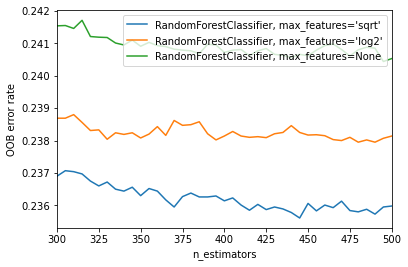

In [89]:
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=42,n_jobs=-1
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=42,n_jobs=-1
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=42,n_jobs=-1
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 300
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### XGBoost (Extreme Gradient Boosting)

In [9]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train,y_train)
y_pred = xgb_cl .predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_pred,y_test,digits=5))

[[ 4925  3134   614]
 [ 2514 11974  1705]
 [  121  2734  2279]]
              precision    recall  f1-score   support

           0    0.56785   0.65146   0.60679      7560
           1    0.73946   0.67111   0.70363     17842
           2    0.44390   0.49565   0.46835      4598

    accuracy                        0.63927     30000
   macro avg    0.58374   0.60607   0.59292     30000
weighted avg    0.65091   0.63927   0.64316     30000



In [10]:
param_gridxgb_cl = { 
    'max_depth' : np.linspace(20,25,6,dtype=int)
}

In [11]:
CV_xgb_cl = GridSearchCV(estimator=xgb_cl, param_grid=param_gridxgb_cl, cv= 5,scoring='f1_macro',n_jobs=-1)
CV_xgb_cl.fit(X_train, y_train)
CV_xgb_cl.best_params_

{'max_depth': 25}

In [23]:
xgb_cl2 = xgb.XGBClassifier(random_state =42,n_estimators=500, learning_rate=0.01, tree_method='auto', max_depth=5)
xgb_cl2.fit(X_train,y_train)
y_pred = xgb_cl2 .predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_pred,y_test,digits=5))

[[ 5225  2802   646]
 [ 2651 11844  1698]
 [   92  2654  2388]]
              precision    recall  f1-score   support

           0    0.60244   0.65575   0.62797      7968
           1    0.73143   0.68462   0.70725     17300
           2    0.46513   0.50465   0.48409      4732

    accuracy                        0.64857     30000
   macro avg    0.59967   0.61501   0.60644     30000
weighted avg    0.65517   0.64857   0.65099     30000



#### Score de XGBoost en CV

In [24]:
CVSxgb_cl2 = cross_val_score(xgb_cl2, X_train,y_train, cv=5,scoring='f1_macro')
print([CVSxgb_cl2,np.average(CVSxgb_cl2)])

[array([0.60419111, 0.61358699, 0.60999337, 0.60323522, 0.61864093]), 0.6099295222018106]
